# Define Dynamic System Model

In [1]:
from sympy import *

# states, inputs, and process noise
X=Matrix(symbols('X[0] X[1] X[2] X[3] X[4] X[5] X[6] X[7] X[8] X[9] X[10] X[11] X[12] X[13] X[14]'))
U=Matrix(symbols('U[0] U[1] U[2] U[3] U[4] U[5]'))
W=Matrix(symbols('W[0] W[1] W[2] W[3] W[4] W[5]'))

# time step
dt=symbols('dt')

# continuous dynamics:
g = 9.81
x,y,z,vx,vy,vz,phi,theta,psi,lx,ly,lz,lp,lq,lr = X
ax,ay,az,p,q,r = U
wx,wy,wz,wp,wq,wr = W

Rx = Matrix([[1, 0, 0], [0, cos(phi), -sin(phi)], [0, sin(phi), cos(phi)]])
Ry = Matrix([[cos(theta), 0, sin(theta)],[0, 1, 0],[-sin(theta), 0, cos(theta)]])
Rz = Matrix([[cos(psi), -sin(psi), 0],[sin(psi), cos(psi), 0], [0, 0, 1]])
R = Rz*Ry*Rx
a_NED = R*Matrix([ax-lx-wx,ay-ly-wy,az-lz-wz])

f_continuous = Matrix([
    vx,
    vy,
    vz,
    a_NED[0],
    a_NED[1],
    a_NED[2] + g,
    (p-lp-wp) + (q-lq-wq)*sin(phi)*tan(theta) + (r-lr-wr)*cos(phi)*tan(theta),
    (q-lq-wq)*cos(phi) - (r-lr-wr)*sin(phi),
    (q-lq-wq)*sin(phi)/cos(theta) + (r-lr-wr)*cos(phi)/cos(theta),
    0,0,0,0,0,0
])


# discretized dynamics:
f = X + f_continuous*dt

# output function (measurement model):
use_phi, use_theta, use_psi = symbols('ekf_use_phi ekf_use_theta ekf_use_psi') # 0 or 1
h = Matrix([x,y,z,use_phi*phi,use_theta*theta,use_psi*psi])

# matrices:
F = f.jacobian(X)
L = f.jacobian(W)
H = h.jacobian(X)

# substitute W with 0
f = f.subs([(w,0) for w in W])
F = F.subs([(w,0) for w in W])
L = L.subs([(w,0) for w in W])
H = H.subs([(w,0) for w in W])

# extra matrices
symmetric_indexing = lambda i,j: int(i*(i+1)/2+j) if i>=j else int(j*(j+1)/2+i)
P = Matrix([[symbols(f'P[{symmetric_indexing(i,j)}]') for j in range(len(X))] for i in range(len(X))])
Q = Matrix([[symbols(f'Q[{i}]') if i==j else '0' for j in range(len(U))] for i in range(len(U))])
R = Matrix([[symbols(f'R[{i}]') if i==j else '0' for j in range(len(h))] for i in range(len(h))])
Z = Matrix([symbols(f'Z[{i}]') for i in range(len(h))])

# Generate EKF code

In [2]:
# from sympy import symbols, sin
from sympy.codegen.ast import CodeBlock, Assignment

# EKF equations from: https://en.wikipedia.org/wiki/Extended_Kalman_filter: Non-additive noise formulation and equations

# PREDICTION STEP
Xpred = f
Ppred = F*P*F.T + L*Q*L.T

# UPDATE STEP
S = H*P*H.T + R
K = P*H.T*S.inverse_LU()
Xup = X + K*(Z - h)
Pup = (eye(len(X)) - K*H)*P

# assignments
Xpred_assigments = [Assignment(symbols(f'X_new[{i}]'), Xpred[i]) for i in range(len(X))]
Ppred_assigments = [Assignment(symbols(f'P_new[{symmetric_indexing(i,j)}]'), Ppred[i,j]) for i in range(len(X)) for j in range(len(X)) if i >= j] # only the lower diagonal will be calculated

Xup_assigments = [Assignment(symbols(f'X_new[{i}]'), Xup[i]) for i in range(len(X))]
Pup_assigments = [Assignment(symbols(f'P_new[{symmetric_indexing(i,j)}]'), Pup[i,j]) for i in range(len(X)) for j in range(len(X)) if i >= j] # only the lower diagonal will be calculated

# PREDICTION STEP
# code generation
prediction_code = CodeBlock(*Xpred_assigments, *Ppred_assigments)
# common subexpression elimination with tmp variables
prediction_code = prediction_code.cse(symbols=(symbols(f'tmp[{i}]') for i in range(10000)))
# simplify
prediction_code = prediction_code.simplify()
# count number of tmp variables
prediction_code_N_tmps = len([s for s in prediction_code.left_hand_sides if s.name.startswith('tmp')])
# generate C code
prediction_code = ccode(prediction_code)

# UPDATE STEP
# code generation
update_code = CodeBlock(*Xup_assigments, *Pup_assigments)
# common subexpression elimination with tmp variables
update_code = update_code.cse(symbols=(symbols(f'tmp[{i}]') for i in range(10000)))
# simplify
update_code = update_code.simplify()
# count number of tmp variables
update_code_N_tmps = len([s for s in update_code.left_hand_sides if s.name.startswith('tmp')])
# generate C code
update_code = ccode(update_code)

In [3]:
# replace sin, cos, tan, pow with sinf, cosf, tanf, powf
prediction_code = prediction_code.replace('sin(', 'sinf(')
prediction_code = prediction_code.replace('cos(', 'cosf(')
prediction_code = prediction_code.replace('tan(', 'tanf(')
prediction_code = prediction_code.replace('pow(', 'powf(')
update_code = update_code.replace('sin(', 'sinf(')
update_code = update_code.replace('cos(', 'cosf(')
update_code = update_code.replace('tan(', 'tanf(')
update_code = update_code.replace('pow(', 'powf(')

print('Prediction code:')
print(prediction_code)
print('Update code:')
print(update_code)

Prediction code:
tmp[0] = cosf(X[8]);
tmp[1] = cosf(X[7]);
tmp[2] = U[0] - X[9];
tmp[3] = tmp[1]*tmp[2];
tmp[4] = U[2] - X[11];
tmp[5] = sinf(X[6]);
tmp[6] = sinf(X[8]);
tmp[7] = tmp[5]*tmp[6];
tmp[8] = sinf(X[7]);
tmp[9] = cosf(X[6]);
tmp[10] = tmp[0]*tmp[9];
tmp[11] = tmp[10]*tmp[8] + tmp[7];
tmp[12] = U[1] - X[10];
tmp[13] = tmp[6]*tmp[9];
tmp[14] = tmp[0]*tmp[5];
tmp[15] = -tmp[13] + tmp[14]*tmp[8];
tmp[16] = dt*(tmp[0]*tmp[3] + tmp[11]*tmp[4] + tmp[12]*tmp[15]);
tmp[17] = tmp[3]*tmp[6];
tmp[18] = tmp[10] + tmp[7]*tmp[8];
tmp[19] = tmp[14] - tmp[6]*tmp[8]*tmp[9];
tmp[20] = -tmp[19];
tmp[21] = tmp[2]*tmp[8];
tmp[22] = tmp[12]*tmp[1];
tmp[23] = tmp[1]*tmp[4];
tmp[24] = tanf(X[7]);
tmp[25] = U[4] - X[13];
tmp[26] = tmp[25]*tmp[5];
tmp[27] = U[5] - X[14];
tmp[28] = tmp[27]*tmp[9];
tmp[29] = tmp[25]*tmp[9];
tmp[30] = tmp[27]*tmp[5];
tmp[31] = 1.0/tmp[1];
tmp[32] = tmp[0]*tmp[1];
tmp[33] = dt*tmp[32];
tmp[34] = -tmp[15];
tmp[35] = dt*tmp[34];
tmp[36] = -tmp[11];
tmp[37] = dt*tmp[36];
tmp

# Write C code

In [13]:
header = f'''
///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
// This file is automatically generated in "Generate Kalman Filter C Code.ipynb" from https://github.com/tudelft/kalman_filter   //
///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

#ifndef EKF_CALC_H
#define EKF_CALC_H

#include <stdint.h>

#define N_STATES {len(X)}
#define N_INPUTS {len(U)}
#define N_MEASUREMENTS {len(h)}

// set to 1 to use phi, theta, psi measurements
float ekf_use_phi;
float ekf_use_theta;
float ekf_use_psi;

// getters
float* ekf_get_X();     // get state vector
float* ekf_get_P();     // get covariance matrix (lower diagonal)

#define ekf_P_index(i,j) ((i>=j) ? ekf_get_P()[i*(i+1)/2+j] : ekf_get_P()[j*(j+1)/2+i])
#define ekf_X_index(i) ekf_get_X()[i]

// setters
void ekf_set_Q(float Q[N_INPUTS]);             // set process noise covariance matrix diagonal
void ekf_set_R(float R[N_MEASUREMENTS]);       // set measurement noise covariance matrix diagonal
void ekf_set_X(float X0[N_STATES]);            // set state vector
void ekf_set_P_diag(float P_diag[N_STATES]);   // set covariance matrix diagonal

// prediction and update functions
void ekf_predict(float U[N_INPUTS], float dt);
void ekf_update(float Z[N_MEASUREMENTS]);

#endif
'''

prediction_code_ = prediction_code.replace('\n','\n\t')
update_code_ = update_code.replace('\n','\n\t')

source = f'''
///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
// This file is automatically generated in "Generate Kalman Filter C Code.ipynb" from https://github.com/tudelft/kalman_filter   //
///////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

#include "ekf_calc.h"
#include <math.h>

float ekf_use_phi;
float ekf_use_theta;
float ekf_use_psi;

float ekf_Q[N_INPUTS];         // Kalman filter process noise covariance matrix (diagonal)
float ekf_R[N_MEASUREMENTS];   // Kalman filter measurement noise covariance matrix (diagonal)

// state
float ekf_X[N_STATES];
float ekf_X_new[N_STATES];

// covariance matrix (lower diagonal) P[i,j] = P_lower_diagonal[i*(i+1)/2+j] (if i>=j)
float ekf_P_lower_diagonal[N_STATES*(N_STATES+1)/2];
float ekf_P_lower_diagonal_new[N_STATES*(N_STATES+1)/2];

// temporary variables
float tmp[{max(prediction_code_N_tmps,update_code_N_tmps)}];

// pointers
float *X = ekf_X;
float *X_new = ekf_X_new;

float *P = ekf_P_lower_diagonal;
float *P_new = ekf_P_lower_diagonal_new;

// renaming
float *Q = ekf_Q;
float *R = ekf_R;

// pointer for swapping
float *swap_ptr;

float* ekf_get_X() {{
    return X;
}}

float* ekf_get_P() {{
    return P;
}}

void ekf_set_Q(float Q[N_INPUTS]) {{
    for (int i=0; i<N_INPUTS; i++) {{
        ekf_Q[i] = Q[i];
    }}
}}

void ekf_set_R(float R[N_MEASUREMENTS]) {{
    for (int i=0; i<N_MEASUREMENTS; i++) {{
        ekf_R[i] = R[i];
    }}
}}

void ekf_set_X(float X0[N_STATES]) {{
    for (int i=0; i<N_STATES; i++) {{
        X[i] = X0[i];
    }}
}}

void ekf_set_P_diag(float P_diag[N_STATES]) {{
    // set P to zeros
    for (int i=0; i<N_STATES*(N_STATES+1)/2; i++) {{
        P[i] = 0.;
    }}
    // set diagonal
    for (int i=0; i<N_STATES; i++) {{
        P[i*(i+1)/2+i] = P_diag[i];
    }}
}}

void ekf_predict(float U[N_INPUTS], float dt) {{
    // PREDICTION STEP X_new, P_new = ...
    {prediction_code_}

    // swap X, X_new and P, P_new pointers
    swap_ptr = X;
    X = X_new;
    X_new = swap_ptr;

    swap_ptr = P;
    P = P_new;
    P_new = swap_ptr;
}}

void ekf_update(float Z[N_MEASUREMENTS]) {{
    // UPDATE STEP X_new, P_new = ...
    {update_code_}

    // swap X, X_new and P, P_new pointers
    swap_ptr = X;
    X = X_new;
    X_new = swap_ptr;

    swap_ptr = P;
    P = P_new;
    P_new = swap_ptr;
}}
'''

with open('c_code/ekf_calc.h','w') as file:
    file.write(header)
with open('c_code/ekf_calc.c','w') as file:
    file.write(source)
    

# Compile C Code

In [5]:
import os
import subprocess
import ctypes
import numpy as np
import importlib
importlib.reload(ctypes)
importlib.reload(subprocess)

# Compile C code and create library

# https://cu7ious.medium.com/how-to-use-dynamic-libraries-in-c-46a0f9b98270
path = os.path.abspath('c_code')
# Remove old library
subprocess.call('rm *.so', shell=True, cwd=path)
# Compile object files
subprocess.call('gcc -fPIC -c *.c', shell=True, cwd=path)
# Create library
subprocess.call('gcc -shared -Wl,-soname,libtools.so -o libtools.so *.o', shell=True, cwd=path)
# Remove object files
subprocess.call('rm *.o', shell=True, cwd=path)

lib_path = os.path.abspath("c_code/libtools.so")
lib = ctypes.CDLL(lib_path)

# define argument types 
lib.ekf_set_Q.argtypes = [ctypes.POINTER(ctypes.c_float)]
lib.ekf_set_R.argtypes = [ctypes.POINTER(ctypes.c_float)]
lib.ekf_set_X.argtypes = [ctypes.POINTER(ctypes.c_float)]
lib.ekf_set_P_diag.argtypes = [ctypes.POINTER(ctypes.c_float)]

lib.ekf_get_X.restype = ctypes.POINTER(ctypes.c_float)
lib.ekf_get_P.restype = ctypes.POINTER(ctypes.c_float)

lib.ekf_predict.argtypes = [ctypes.POINTER(ctypes.c_float), ctypes.c_float]
lib.ekf_update.argtypes = [ctypes.POINTER(ctypes.c_float)]


# Test C code

In [6]:
import csv
import numpy as np

def load_flight_data(file_name):
    with open(file_name) as file:
        reader = csv.reader(file)
        data = list(reader)
        
        # separate header and data
        header = [d for d in data if len(d)==2]
        header = {d[0]: d[1] for d in header}
        
        data = [d for d in data if len(d)>2]
        keys = data[0]
        data = data[1:]
        data = np.array([[float(d) if d else np.nan for d in row] for row in data]) # set empty strings to nan
        data = dict(zip(keys,data.T))
        
        # renaming keys
        data['t'] = data.pop('time')*1e-6 # us to s
        data['t'] -= data['t'][0] # start at 0

        # state estimate
        data['x'] = data.pop('pos[0]')*1e-3 # mm to m
        data['y'] = data.pop('pos[1]')*1e-3 # mm to m
        data['z'] = data.pop('pos[2]')*1e-3 # mm to m
        
        data['vx'] = data.pop('vel[0]')*1e-2 # cm/s to m/s
        data['vy'] = data.pop('vel[1]')*1e-2 # cm/s to m/s
        data['vz'] = data.pop('vel[2]')*1e-2 # cm/s to m/s
        
        quat_scaling = ((127 << 6) - 1) # float from -1 to +1 to VB that takes up 2 bytes max
        data['qw'] = data.pop('quat[0]')/quat_scaling
        data['qx'] = data.pop('quat[1]')/quat_scaling
        data['qy'] = data.pop('quat[2]')/quat_scaling
        data['qz'] = data.pop('quat[3]')/quat_scaling
        
        # quat to eulers
        data['phi'] = np.arctan2(2*(data['qw']*data['qx'] + data['qy']*data['qz']), 1 - 2*(data['qx']**2 + data['qy']**2))
        data['theta'] = np.arcsin(2*(data['qw']*data['qy'] - data['qz']*data['qx']))
        data['psi'] = np.arctan2(2*(data['qw']*data['qz'] + data['qx']*data['qy']), 1 - 2*(data['qy']**2 + data['qz']**2))
        
        
        # optitrack
        data['x_opti'] = data.pop('extPos[0]')*1e-3 # mm to m
        data['y_opti'] = data.pop('extPos[1]')*1e-3 # mm to m
        data['z_opti'] = data.pop('extPos[2]')*1e-3 # mm to m
        
        data['vx_opti'] = data.pop('extVel[0]')*1e-2 # cm/s to m/s
        data['vy_opti'] = data.pop('extVel[1]')*1e-2 # cm/s to m/s
        data['vz_opti'] = data.pop('extVel[2]')*1e-2 # cm/s to m/s
        
        data['phi_opti'] = data.pop('extAtt[0]')/1000 # mrad to rad
        data['theta_opti'] = data.pop('extAtt[1]')/1000 # mrad to rad
        data['psi_opti'] = data.pop('extAtt[2]')/1000 # mrad to rad
        
        # imu (from FLU to FRD)
        gyro_scale = np.pi/180 # deg/s to rad/s
        if bool(float(header['blackbox_high_resolution'])):
            gyro_scale /= 10
        data['p'] = data.pop('gyroADC[0]')*gyro_scale
        data['q'] =-data.pop('gyroADC[1]')*gyro_scale
        data['r'] =-data.pop('gyroADC[2]')*gyro_scale
        
        acc_scale = 9.81/float(header['acc_1G'])
        data['ax'] = data.pop('accSmooth[0]')*acc_scale
        data['ay'] =-data.pop('accSmooth[1]')*acc_scale
        data['az'] =-data.pop('accSmooth[2]')*acc_scale
        
        # onboard ekf
        data['ekf_x'] = data.pop('ekf_pos[0]')*1e-3 # mm to m
        data['ekf_y'] = data.pop('ekf_pos[1]')*1e-3 # mm to m
        data['ekf_z'] = data.pop('ekf_pos[2]')*1e-3 # mm to m
        data['ekf_vx'] = data.pop('ekf_vel[0]')*1e-2 # cm/s to m/s
        data['ekf_vy'] = data.pop('ekf_vel[1]')*1e-2 # cm/s to m/s
        data['ekf_vz'] = data.pop('ekf_vel[2]')*1e-2 # cm/s to m/s
        data['ekf_phi'] = data.pop('ekf_att[0]')/1000 # mrad to rad
        data['ekf_theta'] = data.pop('ekf_att[1]')/1000 # mrad to rad
        data['ekf_psi'] = data.pop('ekf_att[2]')/1000 # mrad to rad
        data['ekf_acc_b_x'] = data.pop('ekf_acc_b[0]')/1000 # mm/s^2 to m/s^2
        data['ekf_acc_b_y'] = data.pop('ekf_acc_b[1]')/1000 # mm/s^2 to m/s^2
        data['ekf_acc_b_z'] = data.pop('ekf_acc_b[2]')/1000 # mm/s^2 to m/s^2
        data['ekf_gyro_b_x'] = data.pop('ekf_gyro_b[0]')*np.pi/180
        data['ekf_gyro_b_y'] = data.pop('ekf_gyro_b[1]')*np.pi/180
        data['ekf_gyro_b_z'] = data.pop('ekf_gyro_b[2]')*np.pi/180
                
        return data

logging frequency: 504.02061046270694 Hz
optitrack frequency: 21.201325353867094 Hz


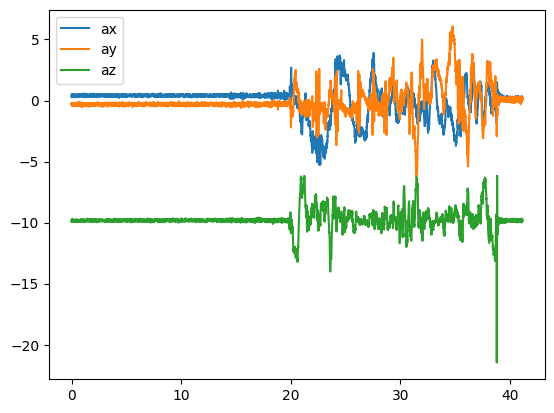

In [7]:
import matplotlib.pyplot as plt

data = load_flight_data('EKF_logging_test8.csv')
    
# logging frequency
freq = 1/np.mean(np.diff(data['t']))
print('logging frequency:',freq,'Hz')

# optitrack frequency
opti_updates = (np.gradient(data['x_opti'])!=0) | (np.gradient(data['y_opti'])!=0) | (np.gradient(data['z_opti'])!=0)
opti_freq = 1/np.mean(np.diff(data['t'][opti_updates]))
print('optitrack frequency:',opti_freq,'Hz')

# plot ax, ay, az
# clos all plots
%matplotlib inline
plt.close('all')
plt.plot(data['t'],data['ax'],label='ax')
plt.plot(data['t'],data['ay'],label='ay')
plt.plot(data['t'],data['az'],label='az')
plt.legend()
plt.show()

In [8]:
# EKF INPUT: U = [ax, ay, az, p, q, r] (IMU)
U_data = np.array([
    data['ax'], data['ay'], data['az'], data['p'], data['q'], data['r']
]).T

# EKF MEASUREMENT: Z = [x, y, z, phi, theta, psi] (Optitrack)
Z_data = np.array([
    data['x_opti'], data['y_opti'], data['z_opti'], data['phi_opti'], data['theta_opti'], data['psi_opti']
]).T

t = data['t']

In [9]:
# INITIALIZE EKF
# initial state
X_init = np.zeros(len(X))
X_init[:3] = Z_data[0,:3]

# initial covariance
P_init = np.array([1.]*len(X))
# P_init[-6:] = 0. # set covariance of IMU bias to 0
# print(P_init)

# process noise covariance
Q_diag = np.array([0.5, 0.5, 0.5, 0.01, 0.01, 0.01])

# measurement noise covariance
R_diag = np.array([0.01, 0.01, 0.01, 0.1, 0.1, 0.1])

lib.ekf_set_Q((ctypes.c_float*len(Q_diag))(*Q_diag))
lib.ekf_set_R((ctypes.c_float*len(R_diag))(*R_diag))
lib.ekf_set_X((ctypes.c_float*len(X_init))(*X_init))
lib.ekf_set_P_diag((ctypes.c_float*len(P_init))(*P_init))

# test ekf_get_state
x = lib.ekf_get_X()
x = np.array([x[i] for i in range(len(X))])
print(x)

# RUN EKF
X_ekf = [X_init]
# Pdiag_ekf = [P_init]

for i in range(1, len(t)):
    # PREDICT
    lib.ekf_predict(
        (ctypes.c_float*len(U_data[i]))(*U_data[i]),
        ctypes.c_float(t[i]-t[i-1])
    )
    
    # UPDATE
    # only update when there is a new measurement
    if np.any(Z_data[i]-Z_data[i-1] != 0):
        # fix yaw
        if Z_data[i,5]-Z_data[i-1,5] > np.pi:
            Z_data[i,5] -= 2*np.pi
        elif Z_data[i,5]-Z_data[i-1,5] < -np.pi:
            Z_data[i,5] += 2*np.pi
        
        lib.ekf_update(
            (ctypes.c_float*len(Z_data[i]))(*Z_data[i])
        )
    
    # get state
    x = lib.ekf_get_X()
    x = np.array([x[i] for i in range(len(X))])
    X_ekf.append(x)
    
    # get Pdiag
    # P_diag = (ctypes.c_float*len(X))()
    # lib.ekf_get_Pdiag(P_diag)
    # P_diag = np.array(P_diag[:])
    # Pdiag_ekf.append(P_diag)


[-3.97900009 -0.52200001  0.009       0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]


In [12]:
# plot trajectory
%matplotlib
X_ekf = np.array(X_ekf)
# Pdiag_ekf = np.array(Pdiag_ekf)


# 5x3 subplots
fig, axs = plt.subplots(5, 3, figsize=(20,20), tight_layout=True, sharex=True)
axs = axs.flatten()

# position
axs[0].plot(t, data['x_opti'], label='x opti')
axs[0].plot(t, data['x'], label='x est')
axs[0].plot(t, X_ekf[:,0], label='x ekf')
axs[0].plot(t, data['ekf_x'], label='x ekf onboard')
axs[0].legend()


axs[1].plot(t, data['y_opti'], label='y opti')
axs[1].plot(t, data['y'], label='y est')
axs[1].plot(t, X_ekf[:,1], label='y ekf')
axs[1].plot(t, data['ekf_y'], label='y ekf onboard')
axs[1].legend()

axs[2].plot(t, data['z_opti'], label='z opti')
axs[2].plot(t, data['z'], label='z est')
axs[2].plot(t, X_ekf[:,2], label='z ekf')
axs[2].plot(t, data['ekf_z'], label='z ekf onboard')
axs[2].legend()

# velocity
axs[3].plot(t, data['vx_opti'], label='vx opti')
axs[3].plot(t, data['vx'], label='vx est')
axs[3].plot(t, X_ekf[:,3], label='vx ekf')
axs[3].plot(t, data['ekf_vx'], label='vx ekf onboard')
axs[3].legend()

axs[4].plot(t, data['vy_opti'], label='vy opti')
axs[4].plot(t, data['vy'], label='vy est')
axs[4].plot(t, X_ekf[:,4], label='vy ekf')
axs[4].plot(t, data['ekf_vy'], label='vy ekf onboard')
axs[4].legend()

axs[5].plot(t, data['vz_opti'], label='vz opti')
axs[5].plot(t, data['vz'], label='vz est')
axs[5].plot(t, X_ekf[:,5], label='vz ekf')
axs[5].plot(t, data['ekf_vz'], label='vz ekf onboard')
axs[5].legend()

# attitude
rad_to_deg = 180/np.pi
axs[6].plot(t, rad_to_deg*data['phi_opti'], label='phi opti')
axs[6].plot(t, rad_to_deg*data['phi'], label='phi est')
axs[6].plot(t, rad_to_deg*X_ekf[:,6], label='phi ekf')
axs[6].plot(t, rad_to_deg*data['ekf_phi'], label='phi ekf onboard')
axs[6].legend()

axs[7].plot(t, rad_to_deg*data['theta_opti'], label='theta opti')
axs[7].plot(t, rad_to_deg*data['theta'], label='theta est')
axs[7].plot(t, rad_to_deg*X_ekf[:,7], label='theta ekf')
axs[7].plot(t, rad_to_deg*data['ekf_theta'], label='theta ekf onboard')
axs[7].legend()

axs[8].plot(t, rad_to_deg*data['psi_opti'], label='psi opti')
axs[8].plot(t, rad_to_deg*data['psi'], label='psi est')
axs[8].plot(t, rad_to_deg*X_ekf[:,8], label='psi ekf')
axs[8].plot(t, rad_to_deg*data['ekf_psi'], label='psi ekf onboard')
axs[8].legend()

# biases
axs[9].plot(t, X_ekf[:,9], label='lx ekf')
axs[9].plot(t, data['ekf_acc_b_x'], label='lx ekf onboard')
axs[9].legend()

axs[10].plot(t, X_ekf[:,10], label='ly ekf')
axs[10].plot(t, data['ekf_acc_b_y'], label='ly ekf onboard')
axs[10].legend()

axs[11].plot(t, X_ekf[:,11], label='lz ekf')
axs[11].plot(t, data['ekf_acc_b_z'], label='lz ekf onboard')
axs[11].legend()

axs[12].plot(t, rad_to_deg*X_ekf[:,12], label='lp ekf')
axs[12].plot(t, rad_to_deg*data['ekf_gyro_b_x'], label='lp ekf onboard')
axs[12].legend()

axs[13].plot(t, rad_to_deg*X_ekf[:,13], label='lq ekf')
axs[13].plot(t, rad_to_deg*data['ekf_gyro_b_y'], label='lq ekf onboard')
axs[13].legend()

axs[14].plot(t, rad_to_deg*X_ekf[:,14], label='lr ekf')
axs[14].plot(t, rad_to_deg*data['ekf_gyro_b_z'], label='lr ekf onboard')
axs[14].legend()

plt.show()

Using matplotlib backend: TkAgg
